In [1]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.mmmtools import *

Using TensorFlow backend.


In [2]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio', img_size=(64, 64))

In [27]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/'
dcgan.discriminator = load_model(dir_models+'discrim_8000.h5')
dcgan.generator = load_model(dir_models+'generat_8000.h5')

In [28]:
accs = np.load(dir_models+'acc_dreal_dfake_8000.npy')

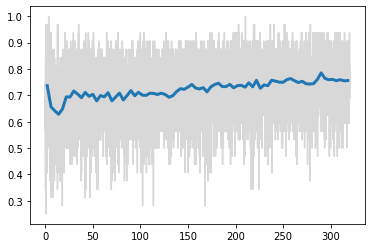

In [29]:
data = (accs[:,1]+accs[:,0])/2.
x_binned, data_binned = bin_history(data, bins=100)
plt.plot(np.arange(len(data))/25., data, color='grey', alpha=0.3)
plt.plot(x_binned/25, data_binned, lw=3)

In [30]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix64_set2.npy'
X_train, X_test, Y_train, Y_test = dcgan.load_training_set(training_path+training_file)
gen_imgs_test = dcgan.generator.predict(X_test)
gen_imgs_train = dcgan.generator.predict(X_train)

In [31]:
patchesY, patchesX = np.load(training_path+training_file)

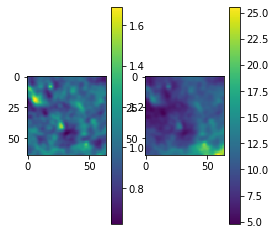

In [32]:
N=589
plt.subplot(131)
plt.imshow(patchesY[N]/patchesX[N])
plt.colorbar()
plt.subplot(132)
plt.imshow(patchesY[N])
plt.colorbar()

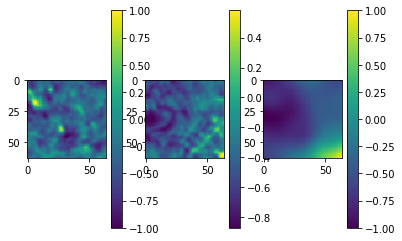

In [33]:
N=589
plt.subplot(131)
plt.imshow(Y_train[N, :, :, 0])
plt.colorbar()
plt.subplot(132)
plt.imshow(gen_imgs_train[N, :, :, 0])
plt.colorbar()
plt.subplot(133)
plt.imshow(X_train[N, :, :, 0])
plt.colorbar()

In [329]:
def normalize_patches(patches_file):
    Y,X = np.load(patches_file)
    Y = Y/X
    Y = np.transpose(Y[:len(Y)])
    X = np.transpose(X[:len(X)])
    X_edges = []
    Y_edges = []
    for i in range(Y.shape[-1]):
        X_edges.append([X[:,:,i].min(), X[:,:,i].max()])
        Y_edges.append([Y[:,:,i].min(), Y[:,:,i].max()])
        Y[:,:,i] = 2*(Y[:,:,i]-Y[:,:,i].min())/(Y[:,:,i].max()-Y[:,:,i].min())-1
        X[:,:,i] = 2*(X[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
    x_train, x_test = split_training_set(X)
    y_train, y_test = split_training_set(Y)
    X_edges = np.array(X_edges)
    Y_edges = np.array(Y_edges)
    return x_train, y_train, X_edges, Y_edges

In [330]:
def normalize_back(image, edges):
    nimage = (image+1)/2.*(edges[1]-edges[0])+edges[0]
    return(nimage)

In [331]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
Ys, Xs = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix320_set2.npy')
Xl_zoom = np.zeros((25*len(Yl), 64, 64))
X_edges = []
for i in range(40):
    Xl_zoom[i*25:(i+1)*25] = divide_image(Yl[i])
X, Y = Xl_zoom, Ys/Xs
Y = np.transpose(Y[:1000])
X = np.transpose(X[:1000])
for i in range(Y.shape[-1]):
    X_edges.append([X[:,:,i].min(), X[:,:,i].max()])
    Y[:,:,i] = 2*(Y[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
    X[:,:,i] = 2*(X[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
x_train, x_test = split_training_set(X)
y_train, y_test = split_training_set(Y)
X_edges = np.array(X_edges)    

In [332]:
gen_imgs_test = dcgan.generator.predict(x_test)
gen_imgs_train = dcgan.generator.predict(x_train)

In [333]:
bnormed_train = np.copy(x_train)
bnormed_gen = np.copy(gen_imgs_train)
for i in range(800):
    bnormed_train[i] = normalize_back(x_train[i], X_edges[i])
    bnormed_gen[i] = (normalize_back(gen_imgs_train[i], X_edges[i]))* bnormed_train[i]

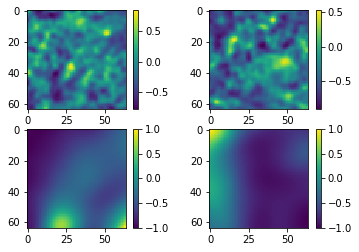

In [334]:
N=100
plt.subplot(221)
plt.imshow(gen_imgs_train[N, :, :, 0])
plt.colorbar()
plt.subplot(222)
plt.imshow(gen_imgs_train[N+1, :, :, 0])
plt.colorbar()
plt.subplot(223)
plt.imshow(X_train[N, :, :, 0])
plt.colorbar()
plt.subplot(224)
plt.imshow(X_train[N+1, :, :, 0])
plt.colorbar()

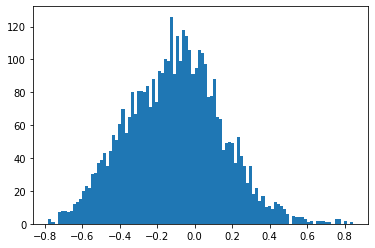

In [335]:
hist=plt.hist(gen_imgs_train[N, :, :, 0].flatten(), bins=100)

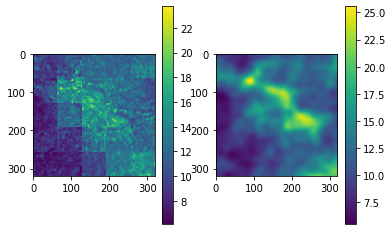

In [336]:
a = 500
b = a+25
small_scale = unify_image(bnormed_gen[a:b])
large_scale = unify_image(bnormed_train[a:b])
plt.subplot(121)
plt.imshow((small_scale)/large_scale)
plt.colorbar()
plt.subplot(122)
plt.imshow((large_scale))
plt.colorbar()

In [337]:
np.std(small_scale/large_scale)

2.709100374599541

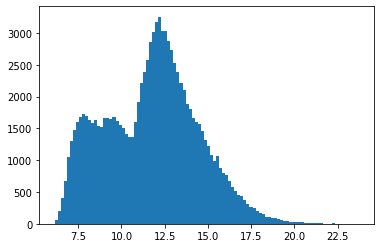

In [338]:
h = plt.hist(small_scale.flatten()/large_scale.flatten(), bins=100)

In [339]:
pysm_ss, pysm_1d = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR12amin_LR1deg_Npix320_set2.npy')

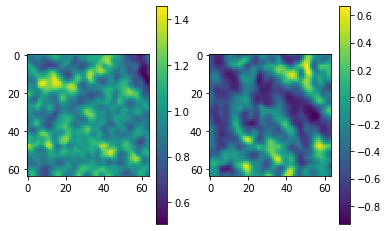

In [362]:
N=34
pysm_only_ss = pysm_ss[N][0:64, 0:64]/pysm_1d[N][0:64, 0:64]
NN_only_ss = gen_imgs_train[N, :, :, 0]
plt.subplot(121)
plt.imshow(pysm_only_ss)
plt.colorbar()
plt.subplot(122)
plt.imshow(NN_only_ss)
plt.colorbar()

In [363]:
NN_norm_back = normalize_back(NN_only_ss, [np.min(pysm_only_ss), np.max(pysm_only_ss)])

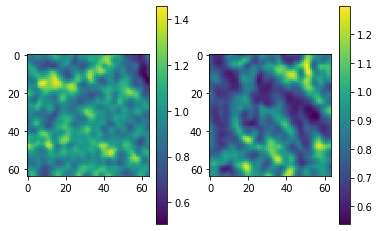

In [364]:
pysm_only_ss = pysm_ss[N][0:64, 0:64]/pysm_1d[N][0:64, 0:64]
NN_only_ss = gen_imgs_train[N, :, :, 0]
plt.subplot(121)
plt.imshow(pysm_only_ss)
plt.colorbar()
plt.subplot(122)
plt.imshow(NN_norm_back)
plt.colorbar()

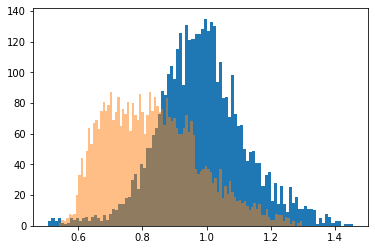

In [365]:
hist = plt.hist(pysm_only_ss.flatten(), bins=100)
hist = plt.hist(NN_norm_back.flatten(), bins=100, alpha=0.5)

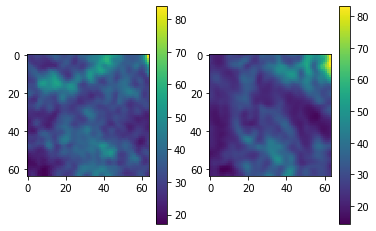

In [366]:
pysm_only_ss = pysm_ss[N][0:64, 0:64]/pysm_1d[N][0:64, 0:64]
NN_only_ss = gen_imgs_train[N, :, :, 0]
plt.subplot(121)
plt.imshow(pysm_ss[N][0:64, 0:64])
plt.colorbar()
plt.subplot(122)
plt.imshow(NN_norm_back*pysm_1d[N][0:64, 0:64])
plt.colorbar()

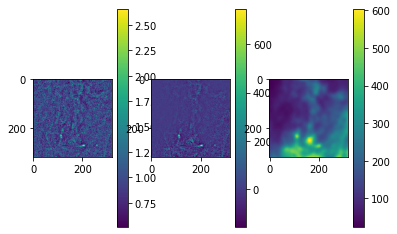

In [346]:
import numpy as np
Npy = 400
plt.subplot(131)
plt.imshow(pysm_ss[Npy]/pysm_1d[Npy])
plt.colorbar()
plt.subplot(132)
plt.imshow((pysm_ss[Npy]-pysm_1d[Npy]))
plt.colorbar()
plt.subplot(133)
plt.imshow(pysm_1d[Npy])
plt.colorbar()

In [258]:
print(np.min(pysm_ss[Npy]/pysm_1d[Npy]), np.max(pysm_ss[Npy]/pysm_1d[Npy]))

0.5145238022160155 2.6548394427985476


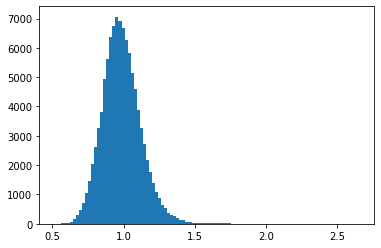

In [259]:
h = plt.hist(pysm_ss[Npy].flatten()/pysm_1d[Npy].flatten(), bins=100)

In [119]:
print(np.std()

145.58465898311326 145.58466


In [198]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix64_set2.npy'

In [199]:
pysm1, pysm5 = np.load(training_path+training_file)

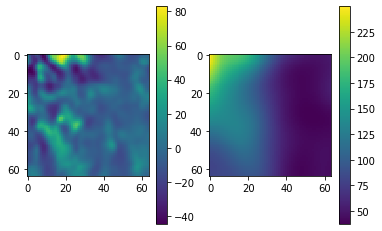

In [200]:
Npy = 1
plt.subplot(121)
plt.imshow(pysm1[1]-pysm5[1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pysm5[1])
plt.colorbar()

In [145]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy'

In [9]:
hfi1, hfi5 = np.load(training_path+training_file)

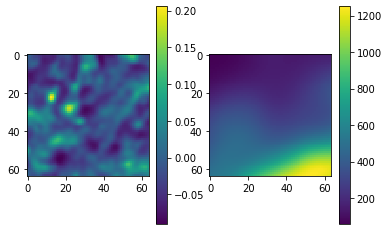

In [67]:
Npy = 56
plt.subplot(121)
plt.imshow(((hfi1[Npy]/hfi5[Npy])-1)/5)
plt.colorbar()
plt.subplot(122)
plt.imshow(hfi5[Npy])
plt.colorbar()

In [68]:
print(np.max(((hfi1[Npy]/hfi5[Npy])-1)/5), np.min(((hfi1[Npy]/hfi5[Npy])-1)/5))

0.2057502550958991 -0.09004038514741627
